In [1]:
from sympy import *
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
def sec(C):
    sec = 1/2 * (trace(C)**2 - trace(C**2))
    return sec

In [3]:
# Identity tensor
I = eye(3)

# Direction vector
e1 = I[:,0]
e2 = I[:,1]
e3 = I[:,2]

In [4]:
# Dilatation coefficients
u, Nu   = symbols(r'u \nu', positive=True)

LambdaH = 1             # Coefficient for homogeneous dilatation
LambdaX = u **(-Nu)     # Coefficient for lengthening in e1 direction (here <1)
LambdaY = u **(-Nu)     # Coefficient for lengthening in e2 direction (here <1)
LambdaZ = u             # Coefficient for lengthening in e3 direction (here >1)

In [5]:
# Deformation matrices
U = I + (LambdaX-1) * np.outer(e1,e1) + (LambdaY-1) * np.outer(e2,e2) + (LambdaZ-1) * np.outer(e3,e3)

# Gradient of the deformation
F = (LambdaH-1) * I + U

# Volume change
J = det(F)

# Right Cauchy-Green strain tensor
C = transpose(F) * F

In [6]:
# Eigenvalues of Right Cauchy-Green strain tensor
Lambda1, Lambda2, Lambda3 = symbols(r'\lambda_1 \lambda_2 \lambda_3')

# Hyperelastic models (incompressible)

# Neo-Hookean
Mu = symbols('\mu')
Values_NH = [1.15]

Psi_NH = Mu/2 * (Lambda1 + Lambda2 + Lambda3 - 3)


# Mooney-Rivlin
Mu, C2 = symbols('\mu C_2')
Values_MR = [1.15, 0.00]

Psi_MR = (Mu/2 - C2) * (Lambda1 + Lambda2 + Lambda3 - 3) + C2 * (1/Lambda1 + 1/Lambda2 + 1/Lambda3 - 3)


# Gent
Mu, Jm = symbols('\mu J_m')
Values_Gn = [1.15, 1.00]

Psi_Gn = - Mu*Jm/2 * ln(1 - (Lambda1 + Lambda2 + Lambda3 - 3) / Jm)


# Demiray
Mu, Beta = symbols(r'\mu \beta')
Values_Dm = [1.15, 1.00]

Psi_Dm = Mu/2 * (exp(Beta*(Lambda1 + Lambda2 + Lambda3 - 3)) - 1) / Beta


# Ogden
Mu, Alpha = symbols(r'\mu \alpha')
Values_Og = [1.15, 2]

Psi_Og = 2*Mu * (Lambda1**(Alpha/2) + Lambda2**(Alpha/2) + Lambda3**(Alpha/2) - 3) / Alpha**2


Psis = [Psi_NH, Psi_MR, Psi_Gn, Psi_Dm, Psi_Og]

In [7]:
for Psi in Psis:
    
    # Derivative with respect to Lambdas (https://en.wikipedia.org/wiki/Hyperelastic_material: incompressible isotropic hyperelastic material)
    T_L1 = Lambda1*Derivative(Psi, Lambda1)*np.outer(e1,e1)
    T_L2 = Lambda2*Derivative(Psi, Lambda2)*np.outer(e2,e2)
    T_L3 = Lambda3*Derivative(Psi, Lambda3)*np.outer(e3,e3)

    p = symbols('p')
    T = T_L1 + T_L2 + T_L3 - p * I       # Add the pressure p for incompressibility
    T = Matrix(T)
    T = T.doit()

    # Replace Eingenvalues
    Lambdas = C.eigenvals()
    Lambdas = list(Lambdas)
    T = T.subs({Lambda1:Lambdas[0], Lambda2:Lambdas[0], Lambda3:Lambdas[1]})

    # No stress over side
    Pressure = solveset(T[0,0], p)
    Pressure = list(Pressure)[0]

    # Replace pressure
    T = T.subs({p:Pressure})

    # Other stresses
    P = T * det(F) * F.inv().transpose()               # Nominal stress
    S = det(F) * F.inv() * T * F.inv().transpose()     # Material stress for J=1

    # Define axial responses
    if Psi == Psi_NH:
        S_U33 = S[2,2].subs({Mu:Values_NH[0]})
        P_U33 = P[2,2].subs({Mu:Values_NH[0]})
        T_U33 = T[2,2].subs({Mu:Values_NH[0]})
        
    elif Psi == Psi_MR:
        S_U33 = S[2,2].subs({Mu:Values_MR[0], C2:Values_MR[1]})
        P_U33 = P[2,2].subs({Mu:Values_MR[0], C2:Values_MR[1]})
        T_U33 = T[2,2].subs({Mu:Values_MR[0], C2:Values_MR[1]})
        
    elif Psi == Psi_Gn:
        S_U33 = S[2,2].subs({Mu:Values_Gn[0], Jm:Values_Gn[1]})
        P_U33 = P[2,2].subs({Mu:Values_Gn[0], Jm:Values_Gn[1]})
        T_U33 = T[2,2].subs({Mu:Values_Gn[0], Jm:Values_Gn[1]})
        
    elif Psi == Psi_Dm:
        S_U33 = S[2,2].subs({Mu:Values_Dm[0], Beta:Values_Dm[1]})
        P_U33 = P[2,2].subs({Mu:Values_Dm[0], Beta:Values_Dm[1]})
        T_U33 = T[2,2].subs({Mu:Values_Dm[0], Beta:Values_Dm[1]})
        
    elif Psi == Psi_Og:
        S_U33 = S[2,2].subs({Mu:Values_Og[0], Alpha:Values_Og[1]})
        P_U33 = P[2,2].subs({Mu:Values_Og[0], Alpha:Values_Og[1]})
        T_U33 = T[2,2].subs({Mu:Values_Og[0], Alpha:Values_Og[1]})

    # Convert expression into numpy function
    # f = lambdify(u, T_U33, 'numpy')
    f = lambdify((Nu, u), P_U33, 'numpy')
    # f = lambdify(u, S_U33, 'numpy')

    if Psi == Psi_NH:
        NH = f
        
    elif Psi == Psi_MR:
        MR = f
        
    elif Psi == Psi_Gn:
        Gn = f
        
    elif Psi == Psi_Dm:
        Dm = f
        
    elif Psi == Psi_Og:
        Og = f   

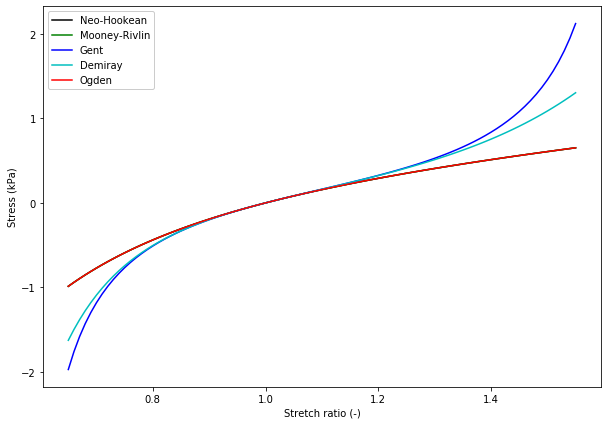

In [18]:
# Plot Results

Nu   = 0.5
Xmin = 0.65
Xmax = 1.55
Delta = 0.01
U33 = np.linspace(Xmin,Xmax,int((Xmax-Xmin)/Delta+1))

plt.rc('figure', figsize=[10,7])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.cla()
ax.plot(U33, NH(Nu,U33),  color = 'k', linestyle = '-', label='Neo-Hookean')
ax.plot(U33, MR(Nu,U33),  color = 'g', linestyle = '-', label='Mooney-Rivlin')
ax.plot(U33, Gn(Nu,U33),  color = 'b', linestyle = '-', label='Gent')
ax.plot(U33, Dm(Nu,U33),  color = 'c', linestyle = '-', label='Demiray')
ax.plot(U33, Og(Nu,U33),  color = 'r', linestyle = '-', label='Ogden')
ax.set_xlabel('Stretch ratio (-)')
ax.set_ylabel('Stress (kPa)')
# plt.xlim([0.8, 1.2])
# plt.ylim([-0.5, 0.5])
plt.legend(loc='upper left', frameon=True, framealpha=1)
plt.show()